# Introduction to Neural Models and PyTorch

The following introduces you, with examples, to some basic aspects of pytorch. A more thorough introduction can be begun [here](https://pytorch.org/tutorials/beginner/basics/intro.html). The main purposes of this introduction is to drive towards building a simple feed-forward neural network. We will build the model together in class. Along the way, I will weave in some introductory materials for neural models. This includes calculating gradients, gradient descent, model layers, forward and backward computations, and more. 

We begin by importing pytorch (called torch) and creating a function which will be useful for ensuring consistent behavior for your model. 

In [ ]:
import torch

In [ ]:
def setSeed():
    #set seed for reproducibility
    torch.manual_seed(2022)

setSeed()

## Building a Neural Model
In this section, we will learn about the basic for building a neural model using pytorch, before turning to implementing a feed forward model. For ease of explanation, we'll imagine we want to implement a simple, one-layer neural model which performs a simple mapping. Namely, $f(2; \theta) \rightarrow 5$. It is easy enough to imagine many functions $f$ parameterized by $\theta$ which will accomplish this. But we will let our model learn its own $\theta$, but restrict our functions $f$ to linear functions (we return this momentarily). Below, we alternate between basic aspects of building a model and the implementation of a model which learns this mapping. To scaffold this, I've created a figure which, at a very high level, sketches the basic components of a neural model and how they fit together. Each part of the figure should make sense to you by the end of this lecture, but for now it may be confusing. It's just here as an outline of what is to come.

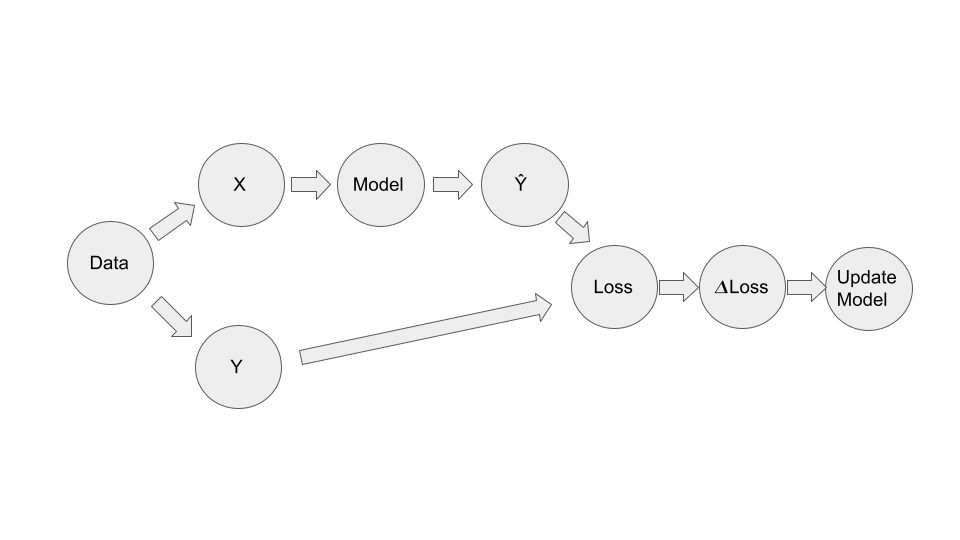

### Class Structure

The core of any pytorch model is building a class which **inherits** from torch.nn.Module. Below, I build a model I name Map which inherits from torch.nn.Module.

In [ ]:
class Map(torch.nn.Module):

    def __init__(self):
        #super is special function which calls the parent class 
        #(here thats torch.nn.Module)
        #We have to initialize our parent class, which 
        #is done here. I'll make sure to include 
        #such basics whenever necesssary, so you 
        #do not have to worry about the details
        super().__init__()
        
        #Discussed below in Linear Layers
        self.W = torch.nn.Linear(1, 1)

    def forward(self, x: torch.tensor):
        """
        Every model should implement a method/function called forward
        which manipulates input data (here assigned the variable x)
        """
        return self.W(x)

The above model is quite simple. It applies a linear transformation (more on this below) to our input data. Reflecting on our goal of building a model which learns a function, $f$, which maps 2 to 5, the use of a linear transformation has restricted the class of functions we want our model to consider. That is, we could imagine $f$ being quadratic, perhaps $f(x) = x^2 + 1$. However, we have restricted our learner to just linear models. Thinking of the relationship between our desired functional mapping and the space of possible functions we are considering is critical in understanding computational modeling, so as we proceed try to keep it in the back of your mind. 

Given this class, we can create an instance of the Map, and see what happens when we pass in 2.

In [ ]:
model = Map()
x = torch.tensor([2.])

model(x)

We see that our models first prediction is a bit off! Presently, the function can be described as $f(2) \rightarrow 0.4271$. We will see, in time, how to fix this by having the model update its weights. But first, let's delve into what torch.nn.Linear is (and then an aside about activation functions).

### Linear Layers

Linear layers are a core part of any model we will be exploring in this class. A pytorch linear layer implements a linear transformation when applied to a variable, x:

$$ \mathbf{x}\mathbf{W}^T + \mathbf{b} $$

This is your basic linear regression function with two sets of parameters, $\mathbf{W}$ and $\mathbf{b}$ (you may be more familiar with this version of the equation $\mathbf{W}\mathbf{x} + \mathbf{b}$. Rather than creating these parameters yourself torch.nn.Linear takes care of this for you (in addition to applying the transformation to a variable). 

More documentation on linear can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). Essentially, Linear takes two inputs: the dimenisonality of the input and the desired dimensionality of the output. Say for example, we expect inputs with 100 features, and we want the output of the linear layer to be 10 features: 

In [ ]:
L = torch.nn.Linear(100, 10)

#20 input elements with 100 features each
X = torch.randn(20, 100)

out = L(X)

#this should be the transformation of our 20 inputs to 10 features 
#so the shape should be 20, 10
print(out.shape)

Let's return to our Map model and dig a bit more into how Linear works. Recall, we created an instance of Linear and set it to the variable self.W. We can see both the weight and the bias (the W and the b) of this variable straightforwardly.

In [ ]:
print(f"The instance of torch.nn.Linear for our model: \n\t{model.W}")
print()
print(f"The W of our model's linear layer: \n\t{model.W.weight}")

print()
print(f"The bias of our model's linear layer: \n\t{model.W.bias}")

We can use W and b to recreate the model's initial prediction.

In [ ]:
prediction = model(x)
print(prediction)

print()
W = model.W.weight
b = model.W.bias

print(x@W.t()+b)

### Activation Functions

Before turning to how we can get our model to learn, it's worth mentioning some other useful pytorch functions. Namely, the activation functions. Our Map model is just linear (in fact, it's just linear regression). 

However, neural networks are often synonymous with non-linear functions. So how do we get them to be non-linear? Well we use activation functions which introduce (sometime quite subtle) non-linearities. Below, I detail some. (The interested reader may be curious about the power of non-linearities. See [Cybenko 1989](https://link.springer.com/article/10.1007/BF02551274) and [Hornik, Stinchcombe, and White 1989](https://cognitivemedium.com/magic_paper/assets/Hornik.pdf) for a proof that feed forward neural networks with one layer and a non-linear activation function are universal function approximaters. Similar results hold for RNNs; see [Schäfer and Zimmermann 2006](https://link.springer.com/chapter/10.1007/11840817_66).)

We will consider two activation functions in todays lecture: softmax and ReLU. I mention sigmoid and some extensions on ReLU in the Appendix. Softmax is used to transform the final output of a neural model into a probability distribution over K labels. That is, we use it for **multi-class classification**. ReLU is used internally to a model to introduce non-linearities between layers of a model.

The first activation function we will consider is the **Softmax** function, which is defined as:

$$\textrm{Softmax}(\mathbf{x}_i) = \frac{e^{\mathbf{x}_i}}{\sum_{j=0} ^{K} e^{\mathbf{x}_j}} $$

where: 

$$ \mathbf{x} = [x_0, x_1, ..., x_K] $$

The softmax function is a generalization of the sigmoid function (which operates element-wise and is used in binary prediction; see the Appendix for further details) to multi-class prediction. That is, we could imagine each element of the vector $\mathbf{x}$ representing one label (or class). Softmax converts this to a probability distribution, where the probability assigned to each element sums to 1. We will use this function as the final layer of our language models to convert the model's output to a probability distribution over the vocabulary.   

 

In [ ]:
#setting dim=-1 tells softmax to normalize relative 
#to the final dimension, in this case there is 
#only one dimension
act = torch.nn.Softmax(dim=-1)
x = torch.randn(10)
print(x)

normedX = act(x)
print(normedX)
print(normedX.sum())

The other activation function we will consider today is **ReLU**, which is definied as:

$$ \textrm{ReLU}(\mathbf{x}) = \textrm{max}(0,\mathbf{x})$$

ReLU is applied element-wise and is often the activation function used internal to the neural model. Notice that ReLU has a sharp change between negative and positive values of $\mathbf{x}$. There are various ways of relaxing this punctuation. Some activation functions commonly used to do just that, include GeLU, ELU, Leaky ReLU. There are pros and cons between all these, but we set aside such issues in this course. See the Appendix for some links to sources and the definitions of these functions. 

In [ ]:
act = torch.nn.ReLU()

x = torch.tensor([-100, -1, 0, 1, 2, 500])

act(x)

### Loss Functions

In order to update a model, we need to know if its current predictions are off and, if so, by how much. We do this with **Loss** functions, which assign a certain cost for errorful output. Below I detail two loss function which we will interact with today. A few others are detailed in the Appendix. 

We will first consider the **Mean Squared Error (MSE) Loss** which is quite common in regression models (i.e. models which predict a continous value; for example, learning to predict amount of CO2 emissions from car model, year, and average speed). MSE is defined as: 

$$ \textrm{MSE}(\hat{y}, y) = \frac{1}{N}(\hat{y}-y)^2 $$

where $N$ is the number of samples (i.e. the length of y), $\hat{y}$ is our model's predictions and y is the gold (or actual) values. Put simply, MSE takes the difference between the model output and the actual output and assigns a high cost to large errors. For example, if our model predicted 10 when it should have predicted 1010, the MSE would be 1000000. I show MSE from pytorch below.

In [ ]:
#The use of reduction='none' ensures that the the 
#loss is calculated by (x_i, y_i) with N=1. 
#Typically, we will instead want the 
#total loss across all examples (which will be the mean of the errors). log
#We accomplish this with removing the reduction argument.
loss = torch.nn.MSELoss(reduction='none')

#Think of each element as one model prediction
y_hat = torch.tensor([0.01, 0.1, 1, 10, 100])
#Think of each element as the desired output value
y = torch.tensor([0.1, 1, 10, 100, 1000])

#Notice how the loss scales 
loss(y_hat, y)


The other loss function we will consider here is the **Cross-Entropy Loss**. As with softmax and sigmoid, the cross-entropy (BCE) loss is a generalization of the binary-cross entropy loss (detailed in the Appendix). That is, BCE loss works with one class, while the cross-entropy loss is for K classes. As such, this loss is used in multi-class prediction (e.g., predicting a part-of-speech label for a given input). Cross-entropy loss is defined as: 

$$ \textrm{CrossEntropy}(\mathbf{\hat{y}}, \mathbf{y}) = - \sum_{j=0} ^{K} \mathbf{y}_j \textrm{log}(\mathbf{\hat{y}}_j)$$ 

where $\mathbf{y}$ and $\mathbf{\hat{y}}$ are vectors of length K (i.e. there are K classes). In the typical use case, we assume that we want our model to predict one class given an input (this can be relaxed but goes outside the scope of the course). That is, in the vector $\mathbf{y}$ the desired class is assigned a value of 1, while all elements are assigned 0. The model prediction, $\mathbf{\hat{y}}$, is the output of the model after the application of softmax (i.e. $\mathbf{\hat{y}}$ is a probability distribution over the K classes). 

In pytorch, the cross-entropy loss expects the input to be **logits**. Logits are the unnormalized model output. In other words, the output of the model before the application of a softmax layer. This is helpful for numerical stability (an issue outside the scope of this class). All you need to know is that you should not use the cross-entropy loss function with the output of a softmax layer. Finally, the cross-entropy function in pytorch expects the target values (i.e. the $\mathbf{y}$) to be either the class labels or the probabilities of each class. 



In [ ]:
loss = torch.nn.CrossEntropyLoss()

#In the following example, we will assume
#we are choosing between 5 labels (i.e. there are 5 classes)
K = 5
#create a random output
y_hat = torch.randn(K)
#let's assume that in our training 
#data the input is actually associated 
#with the 3rd class. 
#Here we use the CrossEntropyLoss
#function with class probabilities (rather than 
# target labels). In other words, our y 
# has 100% assigned to class 3 and 0% to all 
#others
y = torch.zeros(K)
y[2] = 1

print(loss(y_hat, y))

#We can instead use the desire class label. 
#Class 3 is associated with the 2nd index 
# (recall python counts from 0)
# so the label is 2
y = torch.tensor(2)

#Notice that the loss is the same!
print(loss(y_hat, y))


### Gradients

Now that we have a basic model and we've learned about loss functions (which evaluate the correctness of a model), we need some way of updating our model so it learns. What we want to do is update each parameter in our model according to its contribution to the output. That is, if we have one parameter, which leads our model to an incorrect prediction we want to change this parameter. Below I will walk through the basics of how this works for our toy Map model, noting how things generalize. Luckily, when we actual build and train a model with pytorch, all these details will be taken care of for us. At the conclusion of this section, I will show you where one might access such information in pytorch. Ultimately, you won't need to be doing calculus throughout this course, so if you are unsure of some of the details, that's ok. The course is aiming to give you a sense of how things work, so focus on the broad themes. 

For our Map model, we will use the mean squared error loss function, because we are predicting a value given an input (not a probability distribution, for example). Recall that the MSE loss is defined as:

$$ \textrm{MSE}(\hat{y}, y) = \frac{1}{N}(\hat{y}-y)^2 $$

where $N$ is the number of samples (i.e. the length of $\hat{y}$), $\hat{y}$ is our model's predictions and $y$ is the true values.

Recall further that we can think of our model as a function, f, which applies to a single input x: 

$$ \textrm{Map} := f(x) $$

A given instance of Map, m, will be a linear function: 

$$ f(x) = Wx + b $$

The parameters of this model are W and b. That is, W and b will be updated based on our training data. We can use a slightly different notation to express this: 

$$ f(x; W, b) = Wx + b $$

We can think, then, of our function as involving three variables, the training data and the two parameters we will learn. Linking our loss function and our model (assuming $N$=1), we have: 

$$ \textrm{MSE}(\hat{y},y) = (f(x; W, b) - y)^2 $$ 




Ultimately, we want to minimize the loss function (i.e. minimize the error of our model). Learning, then, amounts to finding the parameters which minimize the relevant loss function. In our example, we want to find the parameters, W and b, which minimize $\textrm{MSE}(\hat{y}, y)$. However, we are starting out with initial values of W and b, so instead we want to know how to change W and b, such that we move our function towards minimizing our loss. We can do that by taking the partial derivative of our loss with respect to our parameters. 

x and y are constants, given to us by our training data, so the partial derivate of our loss function with respect to these is 0. Therefore, we focus on the parameters we want to update: namely, W and b. Recalling the chain rule of calculus, we know that: 

$$  \frac{\partial \textrm{MSE}(\hat{y},y)}{\partial W} = \frac{\partial \textrm{MSE}(\hat{y},y)}{\partial f(x;W,b)} \frac{\partial f(x;W,b)}{\partial W} $$

and 

$$  \frac{\partial \textrm{MSE}(\hat{y},y)}{\partial b} = \frac{\partial \textrm{MSE}(\hat{y},y)}{\partial f(x;W,b)} \frac{\partial f(x;W,b)}{\partial b} $$

Turning to each component: 

$$ \frac{\partial f(x,W,b)}{\partial W} = x$$

$$ \frac{\partial f(x,W,b)}{\partial b} = 1 $$

$$ \frac{\partial \textrm{MSE}(x,y)}{\partial f(x,W,b)} = 2(f(x,W,b)-y) $$

Combining these, yields: 

$$ \frac{\partial \textrm{MSE}(\hat{y},y)}{\partial W} = 2(f(x, W, b)-y)*x$$

$$  \frac{\partial \textrm{MSE}(\hat{y},y)}{\partial b}  = 2(f(x, W, b)-y)$$

At present (hopefully on your system too), our model is initialized with $W=-0.2084$ and $b=0.8439$, and thus $f(x,W,b) = -0.2084x + 0.8439$. Additionally, $x=2$ and $y=5$ (we only have one input/output pair). 

Thus $f(x;W,b) = 0.4271$ and

$$ \frac{\partial \textrm{MSE}(\hat{y},y)}{\partial W}  = 2(0.4271-5) * 2 = -18.2916 $$

$$ \frac{\partial \textrm{MSE}(\hat{y},y)}{\partial b}  = 2(0.4271-5) = -9.1458 $$

Calculating these gradients is called **back propagation**. The name follows from the use of the chain rule to successfully calculate the gradient associated with each part of the model. Here, we propagate from our loss to the linear layer to its weights. In pytorch, the gradients are automatically calculated for us (pytorch has a built in differentiation engine called [autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)). We can see the specific gradients associated with the weights (given an input and output) straightforwardly using pytorch. 

In [ ]:
setSeed()

model = Map()

input = torch.tensor([2.])
target = torch.tensor([5.])
loss = torch.nn.MSELoss()

#Make sure you aren't calculating the gradient with respect to older
#outputs (if you comment this out, you can see the gradient accumulating)
model.zero_grad()

prediction = model(input)
error = loss(prediction, target)
print(f"For the input 2, the model predicts {prediction.item()}. The desired output is 5. The current cost is {error.item()}")

print()
#Calculate the gradient
error.backward()
print(f"The gradient associated with W:\n\t{model.W.weight.grad.item()}")
print(f"The gradient associated with b:\n\t{model.W.bias.grad.item()}")



Now that we know the gradient associated with the current weights, we can shift our current weights towards the minimum (by subtracting the weights by the gradients). That is, we inch our weights towards the minimum by subtracting the current gradient from them. This is called **gradient descent**. 

There are three main forms of gradient descent: 
batch gradient descent, stochastic gradient descent, and mini-batch gradient
descent. 
For **batch gradient descent**, we calculate the loss across all 
training examples before updating the model. For
**stochastic gradient descent**, the model is updated after each input. 
Finally, for **mini-batch gradient descent**, the loss is calculated for 
a chunk of the examples and then the weights are updated. 

If
we had 20 training examples, batch gradient descent would calculate 
the loss across all 20 examples and then update the weights, 
stochastic gradient descent would update the weights for each example 
(for a total of 20 model updates), and mini-batch gradient descent 
with a batch size of 10 would calculate the loss and update the model
 in two chunks of 10 examples (for a total of 2 model updates). 
We will usually use mini-batch gradient descent as it reduces the 
computational overhead (e.g., there are less updates) but requires 
less memory usage than batch gradient descent. 

Finally, we often want to scale the gradient in updating our weights (especially in the case of stochastic gradient descent). Otherwise we may rush passed the local minimum. This scaling is typically handled by a hyperparameter called the **learning rate**. We may write the update equation for our present model as: 

$$ W = W - \textrm{lr} * \Delta W $$
$$ b = b - \textrm{lr} * \Delta b $$

where lr is our learning rate (typical values include 0.01 or 0.001) and $\Delta W$ and $\Delta b$ represent the gradient of the the loss with respect to W and b, respectively. With a learning rate of 0.1, we would update W and b accordingly

$$ W = -0.2084 - (-1.82916) = 1.62076$$

$$ b = 0.8439 - (-0.91458) = 1.75848 $$

We can accomplish this in pytorch by:

In [ ]:
lr = .1
#We loop over the parameters in the model (W and b)
#and update them by subtracting the scaled
#gradient of the parameter. We do this in
#place (sub_) which means the same 
#as x -= 1
for p in model.parameters():
    p.data.sub_(p.grad.data * lr)

We can check out work by looking at the new weights.

In [ ]:
print(f"The new W:\n\t{model.W.weight.item()}")
print(f"The new b:\n\t{model.W.bias.item()}")

We can now check out models new prediction (quite the convient change lol...)

In [ ]:
x = torch.tensor([2.])
print(model(x))

In [ ]:
#@title Plot Function
def plot(points: tuple = None, asVector: bool=False, 
         origin: tuple=None):

    import numpy as np
    from matplotlib import pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.patches import FancyArrowPatch
    from mpl_toolkits.mplot3d import proj3d
    
    W = np.linspace(-5, 5, 101)
    
    b = np.linspace(-5, 5, 101)

    # full coordinate arrays
    ww, bb = np.meshgrid(W, b)

    zz = ww*2+bb
    zz = (zz-5)**2

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')

    xmin, xmax, ymin, ymax, zmin, zmax = -25, 25, -25, 25, -25, 25

    #set the title
    ax.set_title("$R^3$", fontsize=50, pad=50)

    # Set identical scales for both axes
    ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-1, ymax+1), zlim=(zmin-1, zmax+1))

    # Create 'x' and 'y' labels placed at the end of the axes
    ax.set_xlabel('W', size=25)
    ax.set_ylabel('b', size=25)
    ax.set_zlabel('z', size=25)

    surf = ax.plot_surface(ww,bb,zz)
    if points:
        for point in points:
            x, y, z = point
            dispx, dispy, dispz = x+0, y+0, z+0
            label = f'({dispx}, {dispy}, {dispz})'
            ax.text(dispx+0.5, dispy+0.5, dispz+0.5, label)
            x = [x]
            y = [y]
            z = [z]
            plt.plot(x, y, z, marker='o', markersize=10, markeredgecolor='black', markerfacecolor='purple')

    plt.show()

In [ ]:
plot(points=[(1.62, 1.75, 0), (-0.2084, 0.8439, ((-0.2084*2+0.8439)-5)**2)])

A cleaner visualization of gradient descent is copied below:


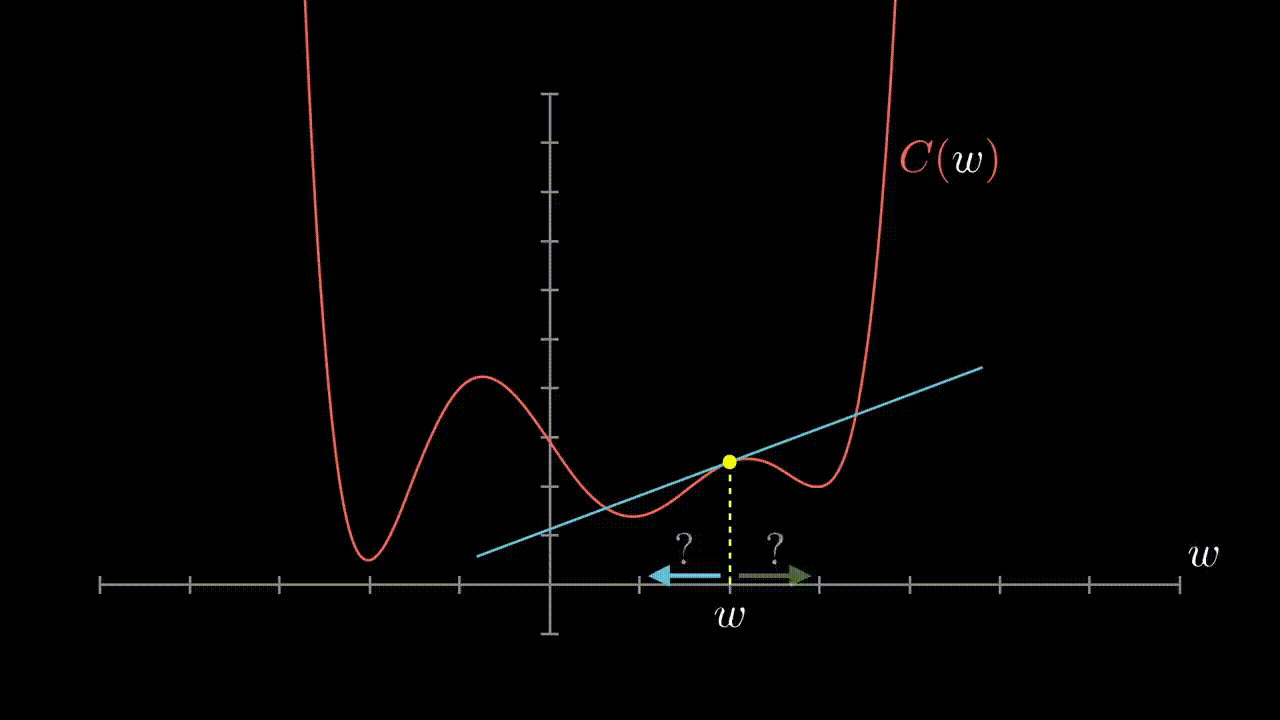

### Optimizers

We turn to the final component of building a model, adding an optimizer. In fact, above we already assumed an optimizer. Namely, we used Euler's method, where we update our approximation of the minimal function by moving in the direction of the scaled gradient. There are many other ways we may possible update our weights in accordance with our data. The specifics of these falls outside the scope of the course. However, we will use one optimizer called Adam. PyTorch has kindly implemented this (and other optimizers). Below, I show how to use Adam (leaving aside the details). All you need to keep in mind is that we use an optimizer to update the weights of our model based on the gradients of our loss function. 

In [ ]:
#Re-initialize our model so we can show an update to our parameters using 
#pytorch's optimizers
model = Map()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

input = torch.tensor([2.])
target = torch.tensor([5.])
loss = torch.nn.MSELoss()

model.zero_grad()

prediction = model(input)
error = loss(prediction, target)

#calculate the gradients
error.backward()

#Update the weights using our optimizer
optimizer.step()

#Let's see the new weights
print(f"The new W:\n\t{model.W.weight.item()}")
print(f"The new b:\n\t{model.W.bias.item()}")

#Let's see the new prediction
#a small step in the right direction...
print(model(x))

We can iterate over this and see how our model updates:

In [ ]:
#Take ten steps (make ten updates)
for _ in range(17):
    #make sure you zero this out!
    optimizer.zero_grad()
    prediction = model(x)
    error = loss(prediction, target)
    #Notice that the loss always decreases. This is a good sign 
    #that our model is learning.
    print(f"The new loss is: {error.item()}")
    error.backward()
    optimizer.step()

print()

print(f"Our final W:\n\t{model.W.weight.item()}")
print(f"Our final b:\n\t{model.W.bias.item()}")
print(f"Our final prediction: {model(x)}")

## Building a Feed Forward Neural Model

Hopefully, the above layed out the basic aspects of pytorch in such a way that you understand, at least in a beginning sense, how to implement a neural model. To reiterate the steps: 

1. Create a model class which extends torch.nn.Module
2. Implement the forward function
3. Gather some training data
4. Set a loss function and a optimizer
5. Get model predictions on data
6. Calculate loss
7. Update model weights
8. Repeate steps 5-7

In the following, we will put this knowledge to the test in building a feed forward neural network which predicts part of speech labels given a word. I've already filled out some aspects of the code, including creating the training data from UD, loading in the training data, and evaluating the model. The task left to do is to use what has already been introduced to build a model. Here, I will detail what has to be done and go over other implementation details. If you are following along in colab, you can implement the various functions, train the model, and check the output in line. If you are not, the script FFNN.py has been included in the repo where you can add the requiste parts. 

### Loading training data and inspecting it

In [ ]:
#Set some typing things
from typing import List, Union, Generator, NewType, Tuple, Dict, Set


We want to build a feed forward network which maps from words (in isolation) to the part of speech (POS) label for that word. Recall from the Tokenizer Lab, that we need to assign an id to the words so that our model can use them. Moreover, we need an class label for each of the possible POS labels. I have already taken care of that in creating the training data ('pos-train.tsv'). Moreover, I have written a function loadData, which loads this data and returns some additional useful things. I copy this code below. Before discussing the model let's look at our data a bit. 

In [ ]:
def loadData(fname: str = 'pos-train.tsv') -> Tuple[List[int], List[int], int, int, Dict[int, str], Dict[int, str], Dict[str, Set[str]]]:
    """
    Simple function which loads the training data from the ud data
    files I created. The input file conform to the following standard:

        First line should be a header which has word, id, total_ids, pos, 
        pos_id, total_pos_ids, and sent (in any order). These columns are:

            word:           the string of the word 
            id:             a unique id for the word type (from 0)
            total_ids:      the total number of word ids
            pos:            the string of the pos label
            pos_id:         a unique id for this pos label type (from 0)
            total_pos_ids:  the total number of pos ids
            sent:           the sentence which contains the word

        For example, the first two lines of pos-train.tsv are (N.B.
        there is a tab seperation which is ignored here and the 
        sentence is truncated for clarity and space): 
        
        word    id   total_ids  pos   pos_id total_pos_ids sent
        forces  0    411        NOUN  0      12            22- Percentage of Americans...

        The first data point, then, means we have a word "forces" which has an 
        id of 0. There are a total of 411 words, and "forces" is labeled 
        as a NOUN. NOUN has an id of 0, for which there are 12 possible ids. 
        The word occurs in the sentence "22- Percentage of Americans...". 

    Args:
        fname (str): name of the file. Default is pos-train.tsv

    Returns:
        X (List[int]):        All the data as ids
        Y (List[int]):        The corresponding pos ids of these data
        inDim (int):     The size of the vocabulary
        outDim (int):    The number of possible pos labels
        id2word (Dict[int,str]):  A dictionary maping word ids to words
        id2pos (Dict[int,str]):   A dictionary mapping pos ids to pos labels
        word2pos (Dict[str,Set[str]]): A dictionary mapping each word to
                                         its possible pos labels as a set

    """

    X = []
    Y = []
    inDim = 0
    outDim = 0
    id2word = {}
    id2pos = {}
    word2pos = {}

    with open(fname, 'r') as f:
        #header mappings
        header = {}
        for idx, head in enumerate(f.readline().strip().split('\t')):
            header[head] = idx
        
        for line in f:
            elements = line.strip().split('\t')
            x = int(elements[header['id']])
            y = int(elements[header['pos_id']])
            inDim = int(elements[header['total_ids']])
            outDim = int(elements[header['total_pos_ids']])

            word = elements[header['word']]
            pos = elements[header['pos']]
            if word not in word2pos:
                word2pos[word] = set([])
            word2pos[word].add(pos)

            id2word[x] = word
            id2pos[y] = pos

            X.append(x)
            Y.append(y)

    return X, Y, inDim, outDim, id2word, id2pos, word2pos



In [ ]:
outputs = loadData()
#loadData returns 7 things discussed in the doc string for the function. 

#Let's look first at some of the typical relationships between words and POS labels
word2pos = outputs[-1]


#I've choosen some words which highlight the key things
targetWords = ['someone', 'hair', 'see', 'change']

for word in targetWords:
    print(f"The word '{word}' has the following POS tags: {word2pos[word]}")


Notice that while some words have one possible POS label (e.g., hair is a NOUN), others have more than one (e.g., change is both a NOUN and a VERB). The other outputs of the loadData function tell us how many words there are, how many pos labels there are, and the specific pos labels. 

In [ ]:
X, Y, inDim, outDim, id2word, id2pos, word2pos = outputs

print(f"There are {len(id2word)} words")
print(f"There are {len(id2pos)} POS labels")
print(f'The POS labels are {list(id2pos.values())}')

#Notice that there are more things in X than words
print(f"There are a total of {len(X)} training examples")

We will train our model on input-output pairs corresponding to (word id, pos id). For example, we can look at 10 random pairs.

In [ ]:
import random

trainPairs = list(zip(X, Y))

samples = random.sample(trainPairs, 10)

for num, pair in enumerate(samples):
    print(f"Example {num} is the pair {pair}")
    print(f"\t\tThis corresponds to the mapping of '{id2word[pair[0]]}' to {id2pos[pair[1]]}")

### Building the model

We begin with a neural network with one hidden layer. Mathematically, it is:

$$ \textrm{HiddenLayer} = \textrm{ActivationFunction}(f(x)) $$
$$ \textrm{FFNN}(x) = \textrm{OutputActivationFunction}(g(\textrm{HiddenLayer})) $$

In words, our input first undergoes a transformation ($f$) and an 
activation function is applied yielding our hidden layer. This hidden layer is further transformed by another function ($g$) before 
a final activation function is applied yielding our model's prediction. 

Thus, there are four things which we have to specify: $f$, $g$, and the two activation functions. For $f$ and $g$ we use seperate linear layers (recalling the discussion above and the use of torch.nn.Linear). For the first activation function, we will use ReLU. Our model is, in effect, performing multi-class classification, so our output activation function would naturally be Softmax (described above). Further, we will be using the cross-entropy loss (which assigns a cost to models in multi-class settings; see above). Recall that pytorch CrossEntropyLoss expects *logits* rather than output probabilities. So we will simply remove this final activation function. Thus, our full model is: 

$$ \textrm{FFNN}(x) = \textrm{LinearLayer2}(\textrm{ReLU}(\textrm{LinearLayer1}(x)) $$

Using the discussion above, fill in the following function to define our model. 


In [ ]:
class FFNN(torch.nn.Module):

    def __init__(self, inputDimensions:int, hiddenDimensions:int, outputDimensions:int):

        super().__init__()

        self.inputDimensions = inputDimensions
        self.hiddenDimensions = hiddenDimensions
        self.outputDimensions = outputDimensions

        #TODO: Your code goes here 
        #Hint: What parameters/activation functions do we need??
        self.LL1 = torch.nn.Linear(self.inputDimensions, self.hiddenDimensions)
        self.LL2 = torch.nn.Linear(self.hiddenDimensions, self.outputDimensions)
        self.act = torch.nn.ReLU()

    def forward(self, x: torch.tensor) -> torch.tensor:
        #TODO: Your code goes here
        hidden = self.act(self.LL1(x))
        logits = self.LL2(hidden)
        return logits

#Useful to create a type for our model for later
FFNNModel = NewType('FFNNModel', FFNN)

Once you've added your code above, let's check some basic aspects of it with some toy settings. 

In [ ]:

inputDim = 10
hiddenDim = 100
outputDim = 5

model = FFNN(inputDim, hiddenDim, outputDim)

#Create an input as one hot encoding 
#of input class 5
x = torch.zeros(10)
x[4] = 1

print(x)

print(model(x))


## Training the Model

Now that we have our model class, how do we go about training it? Well the first thing, we need to do is determine how to treat our input. Recall, that the data is currently pairs of (word id, pos id). What input and output dimensions should we use then? 

We might first think, we'd use an input dimension of 1 and an output dimension of 1. The word and pos ids are integers after all. However, this would be regression, rather than multi-class classification. To understand why regression would be strange in this setting, let's walk through the assumptions regression would make about our data. 

First, suppose we have two word ids, 0 and 1, corresponding to two words, 'the' and 'cat'. Further, suppose, we have two pos ids, 0 and 1, corresponding to the POS "DET" and "NOUN". Using regression we map from our words to these labels. However, this is done assuming the values, on both ends, are continous. Can you think of what issues that would cause? Consider the following questions: 

1. What does an input value of 0 mean? 
2. What does an output value of 1 mean? 
3. Our ids are seperated by 1, what does that mean for the difference between "the" and "cat"? Is that distance meaningful? 
4. What does an input value of 0.2 mean? 
5. What does a model prediction of 0.8877990 mean? 



Hopefully the above points were instructive. Given that we want our model to perform multi-class classification from input classes (i.e. map from word classes to POS classes), we need to format our data accordingly. For our POS output, we can make use of the fact that pytorch's CrossEntropyLoss function can take output class labels. That is we can leave our Y as is. Our input, however, needs to be treated. 

We can use a technique called **one-hot encoding** where we map integers to indices in a vector. In our case, suppose we have 4 word ids (0, 1, 2, 3). We can convert each of these into a vector of length 4, where the id is used as an index. This vector will have values of 0 everywhere but where the id indexes. For example, we can transform 2 into $[0, 0, 1, 0]$. 

While we could accomplish this using torch.zeros and indexing ourselves, pytorch comes ready built with a handy function called [one_hot](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html), which will handle this for us: 

In [ ]:
#Create some sample ids
x = torch.arange(0, 6)
print(x)

#Transform this list into one hot vectors
oneHot = torch.nn.functional.one_hot(x)
print(oneHot)

The following code block will take our X and Y from loadData, one-hot encode the Xs and return batches of size 20. 

In [ ]:
def batches(X: List[int], Y: List[int], batchSize:int=20) -> Generator[Tuple[torch.tensor, torch.tensor], None, None]:
    """
    One-hot encodes X and returns batch of X and Y as torch tensors.

    Args: 
        X (List[int]): Input data of class labels
        Y (List[int]): Ouptut data of class labels
        batchSize (int): Desired number of samples in each batch

    Yields:
        X (torch.tensor): Chunk of X of size (batch size, inputDimensions)
        Y (torch.tensor): Chunk of Y of size (batch size,) 
    """
    #Map X Y to a tensor
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    #One hot encode the X
    X = torch.nn.functional.one_hot(X).float()

    #Now yield batches
    for idx in range(0, X.size()[0], batchSize):
        yield X[idx:idx+batchSize,:], Y[idx:idx+batchSize]

Notice that the above function uses yield instead of return. This means that batches is a **generator**. Rather that returning all the X and Y, this function returns chunks of X and Y in increments. If you link this with a for loop you can access these chunks. See below for the first 10 chunks. 

In [ ]:
for idx, batch in enumerate(batches(X, Y)):
    if idx == 10:
        break
    print(batch)

With this in place, we can build our train function. Recall the discussion of loss functions and optimizers above. You'll use the Adam optimizer, which I have already added to this function. One final thing is the use of **epochs**. In training, we usually iterate over our batches of data some number of times (i.e. we repeat the examples we've already seen). Each time around is called an **epoch**. You should use the epochs variable to control how many times you loop through the data. Notice that our train function takes as input the model and the original X and Y. So you should make sure to use batches to get batches each epoch. 

In [ ]:
def train(X: List[int], Y: List[int], model:FFNNModel, epochs:int=2, lr:int=0.01):
    """
    Train a model on data for some number of epochs with a given learning rate.

    Args: 
        X (List[int]): A list of input ids, where each id is a input class
        Y (List[int]): A list of output ids, where each id is an output class
        model (FFNNModel): An instance of FFNNModel to be trained
        epochs (int): Number of epochs to train for
        lr (int): Learning rate to use for weight updates
    """

    #Set the model to train (in case eval has been set)
    model.train()
    model.zero_grad()

    #Create an instance of an Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #TODO: Add your code below
    #Hint: Remember to create a loss function, then for each epoch, loop through
    #      batches of data, get the model predictions for these data, get the
    #      error, retrieve the gradients, and update the model weights using the 
    #      optimizer. 
    #N.B.: Remember to call optimizer.zero_grad() for each batch, otherwise
    #      The gradient will accumulate across all the data. 
    loss = torch.nn.CrossEntropyLoss()

    for i in range(epochs):
        for idx, batch in enumerate(batches(X, Y)):
            x, y = batch
            optimizer.zero_grad()

            logits = model(x)
            error = loss(logits, y)

            error.backward()

            print(f"Loss is {error.item()}")
            
            optimizer.step()


Run the code below to train your model for 2 epochs. 

In [ ]:

X, Y, inDim, outDim, id2word, id2pos, word2pos = loadData()
hiddenDim = 200

model = FFNN(inDim, hiddenDim, outDim)

train(X, Y, model, epochs=10)

## Evaluating the Model

Now that we the ability to train our models, we may want to evaluate the model to see what it's learned. There are many forms of evaluation (we will cover the more "linguistically" oriented ones in this course). Rather than create more work for you, I've gone ahead and written a small evaluation script which you may find useful. It outputs the accuracy of the trained model on the training data, some errors in classification, and some other cases to think about (we return to this in the discussion). (N.B. In practice, it is, correctly, frowned upon to use the accuracy of our model on our training data as an evaluation of the quality of a model. A model could memorize the training data but perform poorly on new data.)

In [ ]:
def eval(model:FFNNModel, numErrors:int = 10, numSets:int=5):
    """
    Evaluate a model for accuracy on data. Print to stdout errors in prediction.

    Args: 
        model (FFNNModel): An instance of FFNNModel to be evaluated
        numErrors (int): Number of simple errors to return
        numSets (int): Number of more systematic errors to return
    """

    #Load data
    X, Y, inDim, outDim, id2word, id2pos, word2pos = loadData()

    #Set model to eval so no gradients are created
    model.eval()

    #Keep track of times the model is correct
    isCorrect=[]
    #Keep track of errorful predictions
    SimpleErrors = set([])
    MultiErrors = set([])
    for batch in batches(X, Y):
        x, y = batch

        predictions = model(x)
        #Get the top predicted class for each prediction
        predictions = torch.argmax(predictions, dim=-1)

        #Check if the predicted class is correct
        checked = predictions == y
        #Map to int for summing later
        checked = checked.int().tolist()
        isCorrect.extend(checked)

        #Find the errorful cases
        if sum(checked) < len(checked):
            errorsX = torch.argmax(x[~(predictions==y),:], dim=-1).tolist()
            errorsPred = predictions[~(predictions==y)].tolist()
            errorsY = y[~(predictions==y)].tolist()

            for ex, ep, ey in zip(errorsX, errorsPred, errorsY):
                word = id2word[ex]
                predPOS = id2pos[ep]
                goldPOS = id2pos[ey]

                item = f"{word} {predPOS} {goldPOS}"

                if len(word2pos[word]) == 1:
                    SimpleErrors.add(item)
                else:
                    MultiErrors.add(" ".join(item.split(" ")[:-1]))


    print('-------------------------------------------------------------------')
    print(f"Accuracy on train data: {(sum(isCorrect)/len(isCorrect))*100:.2f}%")
    print('-------------------------------------------------------------------')          
        
    print()
    print('-------------------------------------------------------------------')
    print('The following are incorrect predictions by the model:')
    while SimpleErrors and numErrors:
        item = SimpleErrors.pop()
        numErrors -= 1
        word, predPOS, goldPOS = item.split()
        print(f"\tFor '{word}' the gold POS is {goldPOS}, but the model predicted {predPOS}")
    
    print('Consider the following cases:')
    while MultiErrors and numSets:
        item = MultiErrors.pop()
        numSets -= 1
        word, predPOS = item.split()
        possPOS = word2pos[word]
        print(f"\tFor '{word}' the model predicts {predPOS}. The following POS are possible {possPOS}")

Run the following code to see some evaluation of your model

In [ ]:
eval(model)

## Discussion

The following are some discussion questions: 

1. What stands out to you about the output of the eval? 

2. What do you make of the incorrect predictions? Suppose we trained the model for longer what do you expect to happen? 

3. Could we handle new data (ie new words) in our current set up? If so, how? If not, why not? 

4. What do you make of the last group of errors? How might we adapt the model to deal with these errors? What accounts for the model's current behavior? 


In [ ]:
#Add some code here to test your answers


# Appendix

The following survey's some additional aspects of models and pytorch, which may be of interest to those who want to do a deeper dive. 

## Activation Functions



One common activation function (at least outside of NLP) is the **Sigmoid** function, which is defined as:

$$ \textrm{Sigmoid}(x) = \frac{1}{1 + e^{-x}}$$

This function is also called the **Logisitic Function**. Its range is $(0, 1)$, so it is often used to convert an input into a probability. Notice that softmax is a generalization of the sigmoid function, to the case of a probability distribution over many values (instead of just one). 

It is easier to see what I'm saying if we consider a vector such as: 

$$ \mathbf{x} = [1, 5, 9, -10] $$

Applying sigmoid to this will yield: 

$$ \textrm{Sigmoid}(\mathbf{x}) = [0.7311, 0.9933, 0.999, 1.0000] $$

Notice that sigmoid has been applied element-wise, yielding a number in the range of 0 to 1 for each element of our vector $\mathbf{x}$. We might interpret this application of sigmoid as taking in a vector of independent variables and returning a probability for each variable. So above, the probability of the label associated with $\mathbf{x}_0$ is 0.7311. Suppose, $\mathbf{x}_0$ represents the proposition "the input is a cat", then we interpret the value 0.7311 as meaning theres a 73% chance its a cat and a 27% chance its not. Suppose further that $\mathbf{x}_1$ represents the proposition "the input is orange". Then, we interpret the output 0.9933 as meaning there's a 99% chance the input is orange and a 0% chance the input is not. 

These values, however, say nothing on their own about the likelihood that something is an orange cat. To make this even more clear, suppose that $\mathbf{x}_1$ represents the proposition "the input is a tree". Our output, then, simply tells us the probability of each of these properties, but misses the fact that to be a tree is to not be a cat. For this type of relation, we want multi-class classification, and for that, we need softmax.

Below, I show how one uses sigmoid with pytorch. 

In [ ]:
act = torch.nn.Sigmoid()
x = torch.tensor([2.])

out = act(x)
print(out)

x = torch.tensor([100, 2., 1., 0, -6])
print(act(x))

Other common activation functions are relaxations of ReLU. I'll describe GELU here which is used in GPT-2. GELU stands for Gaussian Error Linear Units function, and it is defined as:

$$ \textrm{GELU}(x) = x * \Phi(x) $$

Where $\Phi(x)$ is the cumulative distribution function for a gaussian distribution. The application of GELU to a input looks like:

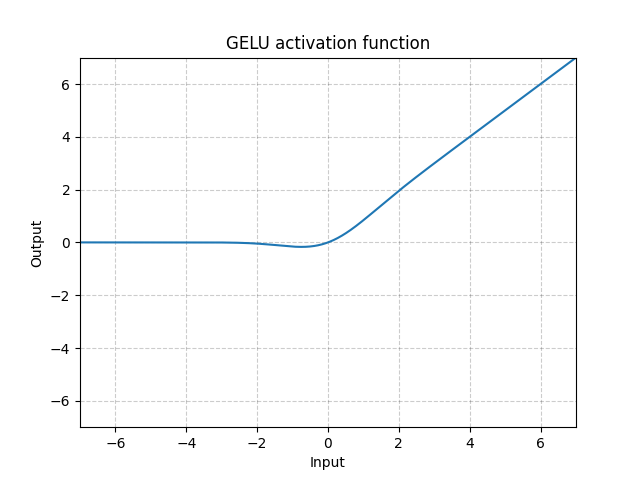

## Loss Functions

Another common loss function is the **Binary Cross-Entropy (BCE) Loss** which is used in binary prediction tasks. As such, the model output is usually transformed by Sigmoid before being passed to this function. For a single input/output pair, BCE is defined as: 

$$ \textrm{BCE}(\hat{y}, y) = -[y \textrm{log}(\hat{y}) + (1-y)\textrm{log}(1-\hat{y})] $$

Put simply, BCE assigns a cost to a model which assigns incorrect probability to a prediction. For a more detailed discussion of this loss and its relationship to entropy, see the following [blog post](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a). We will set these issues aside for this class (there's already a lot for you to juggle after all). 

PyTorch also includes a version of BCE which will take the the model outputs prior to a sigmoid transformation. It is called BCEwithLogitsLoss. It is often helpful to use loss functions which operate on model logits, usually for numerical stability reasons. But this falls outside the scope of this course. I demonstrate both below. 


In [ ]:
loss = torch.nn.BCELoss()

#Imagine our model has predicted a 
#probability of 0.2 given some input. 
#Perhaps, it is the likelihood
#of rain given some measurements
#of the weather
y_hat = torch.tensor([0.2])

#Imagine the following is the 
#true probability assigned 
#to an input. In the case discussed
#above, this might be that the 
#chance of rain given the measurements
#is actually 100% (our model is bad)
y = torch.tensor([1.])

print(f"Simple BCELoss for y_hat = 0.2 and y = 1:\n\t{loss(y_hat, y)}")

#Notice that the loss decreases as x 
#approaches the gold label
#
#Here again we set reduction to 'none'
#so you can see the by-item loss
loss = torch.nn.BCELoss(reduction='none')

y_hat = torch.tensor([0.2, 0.4, 0.6, 0.8, 0.98, 1.])
y = torch.tensor([1., 1., 1., 1., 1., 1.])

print(f"For y = 1, a range of y_hats {y_hat}, the losses are:\n\t{loss(y_hat, y)}")

#Futher, notice that the loss doesn't obtain zero 
#in all cases. What matters for loss functions
#is that we minimize them for a set of
#(x, y) pairs. We return to minimization with 
#graidents below. But consider:

y_hat = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
y = torch.zeros(y_hat.shape)
#set all values to 0.5, that is we want to predict 0.5 for all inputs above
y[:] = 0.5
print()
#Notice where the minimum value is!
print(f"For y = 0.5, a range of y_hats {y_hat}, the losses are:\n\t:{loss(y_hat, y)}")
print(f"Notice how the minimum occurs with a loss of 0.6931")

We will not be using other loss functions in this class, but the interested reader can consulate PyTorch's [API ](https://pytorch.org/docs/stable/nn.html#loss-functions)for further loss functions. All models in this class use either binary cross entropy or cross entropy. 